In [1]:
## loading required libraries
import math
import re
import sys
import json
import itertools
import string
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

In [73]:
# Global variables
START_TOKEN = "<start>"
STOP_TOKEN = "<stop>"
UNK_TOKEN = '<unk>'

URL_TOKEN = "<url>"
RT_TOKEN = "<rt>"
MENTION_TOKEN = "<mention>"
HASHTAG_TOKEN = "<hashtag>"
NUMBER_TOKEN = "<number>"
EMOTICON_TOKEN = "<emoticon>"
SMILEY_TOKEN = "<smiley>"

In [74]:
# loading data into a list which contains tweets as tuple objects
def read_data(file_path):
    tweets = []
    with open(file_path, 'r') as f:
        for line in f:
            tweet = ()
            tweet += tuple(json.loads(line))
            tweets.append(tweet)
    return tweets

In [75]:
train_tweets = read_data('/home/lilly/cse517/hw2/hw2-data/CSE517_HW_HMM_Data/twt.train.json')
dev_tweets = read_data('/home/lilly/cse517/hw2/hw2-data/CSE517_HW_HMM_Data/twt.dev.json')
test_tweets = read_data('/home/lilly/cse517/hw2/hw2-data/CSE517_HW_HMM_Data/twt.test.json')

In [76]:
print ("Length of tweets in training data =", len(train_tweets))
print ("Length of tweets in dev data =", len(dev_tweets))
print ("Length of tweets in test data =", len(test_tweets))
print ("\n")
print ("Average length of tweet in training data =", np.mean([len(line) for line in train_tweets]))
print ("Average length of tweet in dev data =", np.mean([len(line) for line in dev_tweets]))
print ("Average length of tweet in test data =", np.mean([len(line) for line in test_tweets]))

Length of tweets in training data = 50000
Length of tweets in dev data = 5000
Length of tweets in test data = 5000


Average length of tweet in training data = 14.5955
Average length of tweet in dev data = 14.6978
Average length of tweet in test data = 14.7046


In [77]:
pairs = []

In [78]:
# extracting word vocabulary, tag vocabulary and word-tag pair dict
def get_vocab_and_POStags(tweets, pairs):
    vocab_dict = {}
    tags_dict = {}
    for tweet in tweets:
        for pair in tweet:
            word = pair[0]
            # .encode('ascii', 'ignore').decode("utf-8")
            vocab_dict[word] = vocab_dict.get(word, 0) + 1
            tags_dict[pair[1]] = tags_dict.get(pair[1], 0) + 1
            pairs.append(tuple(pair))
    pair_dict = Counter(pairs)
    return vocab_dict, tags_dict, pair_dict

In [79]:
train_vocab_dict, train_tags_dict, pair_dict = get_vocab_and_POStags(train_tweets, pairs)

In [80]:
print ("Training data stats:")
print ("count of unique words in Vocabulary =", len(train_vocab_dict.keys()))
print ("count of unique tags =", len(train_tags_dict.keys()))
print ("count of unique word-tag pair =", len(pair_dict.keys()))

Training data stats:
count of unique words in Vocabulary = 128006
count of unique tags = 24
count of unique word-tag pair = 135871


In [81]:
print (train_tags_dict.keys())

dict_keys(['~', '@', 'L', 'R', 'A', ',', 'O', 'V', 'P', 'N', '$', 'U', '#', 'D', '^', '&', 'T', '!', 'X', 'G', 'E', 'Z', 'S', 'Y'])


In [82]:
dev_vocab_dict, dev_tags_dict, pair_dict = get_vocab_and_POStags(dev_tweets, pairs)

In [234]:
print ("Dev data stats:")
print ("count of unique words in Vocabulary =", len(dev_vocab_dict.keys()))
print ("count of unique tags =", len(dev_tags_dict.keys()))
print ("count of unique word-tag pair (overall) =", len(pair_dict.keys()))

Dev data stats:
count of unique words in Vocabulary = 21429
count of unique tags = 24
count of unique word-tag pair (overall) = 146114


In [84]:
'''Need to deal with the following:
* HASHTAG
* MENTION
* URL
* NUMBERS not in HASH
* EMOJIS
* SMILEYS
* RT (retweet)
'''
# https://stackoverflow.com/questions/26568722/remove-unicode-emoji-using-re-in-python#26568779

RT_REGEX = re.compile("^RT")
MENTION_REGEX = re.compile(r"(@[a-zA-Z0-9_]+)")
HASHTAG_REGEX = re.compile(r"(#[\w\d]+)")
NUMBER_REGEX = re.compile(r"(^|\s)(\-?\d+(?:\.\d)*|\d+)")
URL_REGEX = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

try:
    # Wide UCS-4 build
    EMOTICON_REGEX = re.compile(u'['
        u'\U0001F300-\U0001F64F'
        u'\U0001F680-\U0001F6FF'
        u'\u2600-\u26FF\u2700-\u27BF]+', 
        re.UNICODE)
except re.error:
    # Narrow UCS-2 build
    EMOTICON_REGEX = re.compile(u'('
        u'\ud83c[\udf00-\udfff]|'
        u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
        u'[\u2600-\u26FF\u2700-\u27BF])+', 
        re.UNICODE)
    
SMILEY_REGEX = re.compile(r"(?:X|:|;|=)(?:-)?(?:\)|\(|O|D|P|S){1,}", re.IGNORECASE)

In [65]:
dev_train_mismatch = {}
for w, v in dev_vocab_dict.items():
    if w not in train_vocab_dict.keys():
        dev_train_mismatch[w] = v
        
print (sum(dev_train_mismatch.values()))
print (len(dev_train_mismatch.keys()))

3279
3156


In [66]:
train_vocabu = pd.DataFrame(list(train_vocab_dict.items()), columns=['word', 'count'])
train_vocabu['count'].sum()

729775

In [129]:
## finding the threshold for UNK cutoff based on the training and dev corpus coverage
training_vocab_coverage = []
training_corpus_coverage = []
dev_vocab_coverage = []
dev_corpus_coverage = []

for n in range(1,15,1):
    train_unk_overall = train_vocabu.loc[train_vocabu['count'] <= n].sum(axis=0)['count']
    train_unk_vocab = train_vocabu.loc[train_vocabu['count'] <= n]['word'].tolist()
    training_vc = (1 - len(train_unk_vocab)/len(train_vocab_dict.keys()))*100
    training_cc = (1 - train_unk_overall/sum(train_vocab_dict.values()))*100
    
    training_vocab_coverage.append(training_vc)
    training_corpus_coverage.append(training_cc)
    print ("Training Vocab Coverage at", n, "=",  training_vc)
    print ("Training Corpus Coverage at", n,  "=", training_cc)
    
    dev_unk_overall = 0
    dev_unk_vocab = 0
    for k,v in dev_vocab_dict.items():
        if k in train_unk_vocab:
            dev_unk_overall += v
            dev_unk_vocab += 1
            
    dev_vc = (1- (len(dev_train_mismatch.keys()) + dev_unk_vocab)/len(dev_vocab_dict.keys()))*100
    dev_cc = (1- (sum(dev_train_mismatch.values()) + dev_unk_overall)/sum(dev_vocab_dict.values()))*100
    dev_vocab_coverage.append(dev_vc)
    dev_corpus_coverage.append(dev_cc)
    print ("Dev Vocab Coverage at", n, "=", dev_vc)
    print ("Dev Corpus Coverage at", n, "=", dev_cc)
    print ("\n")

Training Vocab Coverage at 1 = 28.242766232474892
Training Corpus Coverage at 1 = 92.08893151998903
Dev Vocab Coverage at 1 = 53.214450220438245
Dev Corpus Coverage at 1 = 89.95631999346841


Training Vocab Coverage at 2 = 18.46475091975738
Training Corpus Coverage at 2 = 89.9329245315337
Dev Vocab Coverage at 2 = 47.13430282292558
Dev Corpus Coverage at 2 = 88.54114221175958


Training Vocab Coverage at 3 = 14.141891220045743
Training Corpus Coverage at 3 = 88.50316878489946
Dev Vocab Coverage at 3 = 42.811081134434424
Dev Corpus Coverage at 3 = 87.481119623345


Training Vocab Coverage at 4 = 11.60510092472904
Training Corpus Coverage at 4 = 87.38446781542257
Dev Vocab Coverage at 4 = 39.231427255379344
Dev Corpus Coverage at 4 = 86.56941855243642


Training Vocab Coverage at 5 = 9.861290643332998
Training Corpus Coverage at 5 = 86.42321263403103
Dev Vocab Coverage at 5 = 36.15187208001579
Dev Corpus Coverage at 5 = 85.71214739620896


Training Vocab Coverage at 6 = 8.558715322660838

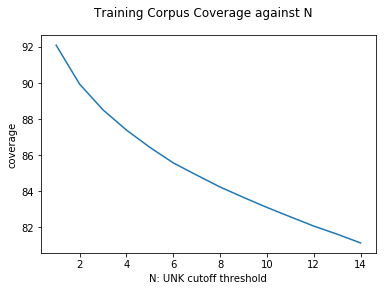

In [130]:
fig = plt.figure()
plt.plot(list(range(1,15)), training_corpus_coverage)
fig.suptitle('Training Corpus Coverage against N', fontsize=12)
plt.ylabel('coverage', fontsize=10)
plt.xlabel('N: UNK cutoff threshold', fontsize=10)
fig.savefig('training_cc.jpg')

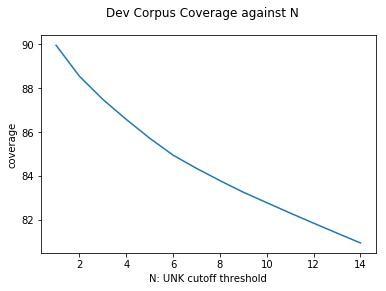

In [131]:
fig = plt.figure()
plt.plot(list(range(1,15)), dev_corpus_coverage)
fig.suptitle('Dev Corpus Coverage against N', fontsize=12)
plt.ylabel('coverage', fontsize=10)
plt.xlabel('N: UNK cutoff threshold', fontsize=10)
fig.savefig('dev_cc.jpg')

In [85]:
# updating vocab, tags and pair dictionary (based on regex match for word (English word in tweets))

# this also outputs a list of list of tags which contain STOP_TOKEN which we will use to evaluate
# the transition probabilities for bigram and trigram HMM

def update_vocab_tags_pair_dict(tweets, threshold, old_pair_dict):
    vocab_dict = {}
    tags_dict = {}
    tags_sentences = []
    
    for tweet in tweets:
        tag_sent = []
        for pair in tweet:
            word = pair[0]
            if bool(URL_REGEX.match(word)):
                word = URL_TOKEN
            elif bool(RT_REGEX.match(word)):
                word = RT_TOKEN
            elif bool(MENTION_REGEX.match(word)):
                word = MENTION_TOKEN
            elif bool(HASHTAG_REGEX.match(word)):
                word = HASHTAG_TOKEN
            elif bool(NUMBER_REGEX.match(word)):
                word = NUMBER_TOKEN
            elif bool(EMOTICON_REGEX.match(word)):
                word = EMOTICON_TOKEN
            elif bool(SMILEY_REGEX.match(word)):
                word = SMILEY_TOKEN
            
            tags_dict[pair[1]] = tags_dict.get(pair[1], 0) + 1
            vocab_dict[word] = vocab_dict.get(word, 0) + 1
#             pair_dict[(word, pair[1])] = pair_dict.get((word, pair[1]), 0) + 1
            tag_sent.append(pair[1])
        tags_dict[STOP_TOKEN] = tags_dict.get(STOP_TOKEN, 0) + 1
        tag_sent.append(STOP_TOKEN)
        tags_sentences.append(tag_sent)
        
    vocab_dict[UNK_TOKEN] = 0
    unk_vocab = set()
    for k, v in vocab_dict.items():
        if v <= threshold:
            unk_vocab.add(k)
            vocab_dict[UNK_TOKEN] += v
    
            
    print (len(unk_vocab))
    
    for word in unk_vocab:
        del vocab_dict[word]
        
    
    new_pair_dict = old_pair_dict.copy()
    for pair, v in old_pair_dict.items():
        word = pair[0]
        
        if bool(URL_REGEX.match(word)):
            new_pair_dict[(URL_TOKEN, pair[1])] = new_pair_dict.get((URL_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]

        elif bool(RT_REGEX.match(word)):
            new_pair_dict[(RT_TOKEN, pair[1])] = new_pair_dict.get((RT_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]

        elif bool(MENTION_REGEX.match(word)):
            new_pair_dict[(MENTION_TOKEN, pair[1])] = new_pair_dict.get((MENTION_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]
            
        elif bool(HASHTAG_REGEX.match(word)):
            new_pair_dict[(HASHTAG_TOKEN, pair[1])] = new_pair_dict.get((HASHTAG_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]
        
        elif bool(NUMBER_REGEX.match(word)):
            new_pair_dict[(NUMBER_TOKEN, pair[1])] = new_pair_dict.get((NUMBER_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]

        elif bool(EMOTICON_REGEX.match(word)):
            new_pair_dict[(EMOTICON_TOKEN, pair[1])] = new_pair_dict.get((EMOTICON_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]

        elif bool(SMILEY_REGEX.match(word)):
            new_pair_dict[(SMILEY_TOKEN, pair[1])] = new_pair_dict.get((SMILEY_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]
            
        elif word not in vocab_dict.keys():
            new_pair_dict[(UNK_TOKEN, pair[1])] = new_pair_dict.get((UNK_TOKEN, pair[1]),0) + v
            del new_pair_dict[pair]
    
    return vocab_dict, tags_dict, new_pair_dict, tags_sentences

In [86]:
train_vocab_dict_new, train_tags_dict,new_pair_dict, train_tags_sentences = update_vocab_tags_pair_dict(train_tweets, 1, pair_dict)

32049


In [88]:
print ("Training data stats:")
print ("count of unique words in Vocabulary =", len(train_vocab_dict_new.keys()))
print ("count of unique tags =", len(train_tags_dict.keys()))
print ("count of unique word-tag pair =", len(new_pair_dict.keys()))
print ("Number of tags-sentences = ", len(train_tags_sentences))

Training data stats:
count of unique words in Vocabulary = 21773
count of unique tags = 25
count of unique word-tag pair = 28513
Number of tags-sentences =  50000


In [89]:
train_tags_dict

{'~': 49001,
 '@': 43095,
 'L': 9539,
 'R': 31098,
 'A': 36842,
 ',': 70893,
 'O': 41922,
 'V': 100069,
 'P': 59019,
 '<stop>': 50000,
 'N': 100677,
 '$': 13255,
 'U': 29758,
 '#': 16839,
 'D': 42689,
 '^': 48824,
 '&': 12063,
 'T': 2998,
 '!': 6642,
 'X': 556,
 'G': 6821,
 'E': 5273,
 'Z': 1504,
 'S': 386,
 'Y': 12}

In [90]:
# Unigram LM, outputs unigram probability dict (doesn't contain STOP_TOKEN)
class unigram_LM():
    def __init__(self, data):
        self.unigrams = {}
        for sent in data:
            for i in range(0, len(sent)):
                self.unigrams[sent[i]] = self.unigrams.get(sent[i], 0) + 1

    def get_unigram_prob_dict(self):
        prob_dict = {}
        for key, value in self.unigrams.items():
            prob_dict[key] = float(value) / float(sum(self.unigrams.values()))
        return prob_dict

In [91]:
tags_ULM = unigram_LM(train_tags_sentences)
unigram_prob_dict = tags_ULM.get_unigram_prob_dict()
print (sum(unigram_prob_dict.values()))

print (unigram_prob_dict)


tags_overall = list(tags_ULM.unigrams.keys())
tags_overall.pop(9)
print (tags_overall)
print (len(tags_overall))

1.0
{'~': 0.06283992177230611, '@': 0.05526594209868231, 'L': 0.01223301593408355, 'R': 0.03988073482735405, 'A': 0.04724696226475586, ',': 0.09091468692892181, 'O': 0.053761662017889775, 'V': 0.12833060818825942, 'P': 0.0756872174665769, '<stop>': 0.0641210605623417, 'N': 0.12911032028469752, '$': 0.016998493155076785, 'U': 0.03816229040428329, '#': 0.02159469077618544, 'D': 0.0547452790869161, '^': 0.06261293321791542, '&': 0.015469847071270559, 'T': 0.003844698791318008, '!': 0.008517841685101472, 'X': 0.0007130261934532397, 'G': 0.008747395081914655, 'E': 0.006762207046904556, 'Z': 0.0019287615017152383, 'S': 0.0004950145875412779, 'Y': 1.5389054534962007e-05}
['~', '@', 'L', 'R', 'A', ',', 'O', 'V', 'P', 'N', '$', 'U', '#', 'D', '^', '&', 'T', '!', 'X', 'G', 'E', 'Z', 'S', 'Y']
24


In [92]:
# estimating emission probability from tags to english words
# Need to create emission_prob dict for each data set since the text pre-processing (like REGEX based 
# substituion and UNKing are done in this step)

# The estimates are calculated using the word-tag pair dict and tags dict derived from the training dataset

def emission_prob(data, tags_dict, pair_dict, vocab_dict):
    
    emission_prob  = {}
    for tag in tags_overall:
        for tweet in data:
            for pair in tweet:
                word = pair[0]
                if word in vocab_dict:
                    emission_prob[(word,tag)] = pair_dict.get((word,tag),0)/tags_dict[tag]
                else:
                    if bool(URL_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((URL_TOKEN,tag),0)/tags_dict[tag]
                        
                    elif bool(RT_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((RT_TOKEN,tag),0)/tags_dict[tag]
                        
                    elif bool(MENTION_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((MENTION_TOKEN,tag),0)/tags_dict[tag]
                        
                    elif bool(HASHTAG_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((HASHTAG_TOKEN,tag),0)/tags_dict[tag]
                          
                    elif bool(NUMBER_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((NUMBER_TOKEN,tag),0)/tags_dict[tag]            
                    
                    elif bool(EMOTICON_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((EMOTICON_TOKEN,tag),0)/tags_dict[tag]
                        
                    elif bool(SMILEY_REGEX.match(word)):
                        emission_prob[(word,tag)] = pair_dict.get((SMILEY_TOKEN,tag), 0)/tags_dict[tag]
                        
                    else: 
                        emission_prob[(word,tag)] = pair_dict.get((UNK_TOKEN,tag),0)/tags_dict[tag]
    return emission_prob

In [93]:
train_emission_prob = emission_prob(dev_tweets, train_tags_dict, new_pair_dict, train_vocab_dict_new)

In [94]:
train_emission_prob[('will', 'V')]

0.012431422318600166

In [96]:
# Bigram LM, outputs bigram transition dict (doesn't contain (START_TOKEN, START_TOKEN))

class bigram_LM(unigram_LM):
    def __init__(self, data):
        unigram_LM.__init__(self, data)
        self.bigrams = {}
        for sent in data:
            self.bigrams[(START_TOKEN, sent[0])] = self.bigrams.get((START_TOKEN, sent[0]), 0) + 1
            for i in range(0, len(sent)-1, 1):
                self.bigrams[(sent[i], sent[i+1])] = self.bigrams.get((sent[i], sent[i+1]), 0) + 1
                    
    def get_bigram_prob_dict(self):
        prob_dict = {}
        self.unigrams[START_TOKEN] = self.unigrams[STOP_TOKEN]
#         print(self.unigrams)
        for key, value in self.bigrams.items():
#             print (key, value)
            prob_dict[key] = value / self.unigrams[key[0]]
        return prob_dict

In [105]:
# Trigram LM, outputs trigram transition dict 

class trigram_LM(bigram_LM):
    def __init__(self, data):
        bigram_LM.__init__(self, data)
        self.trigrams = {}
        for sent in data:
            for i in range(len(sent)-2):
                if (sent[i], sent[i+1], sent[i+2]) not in self.trigrams.keys():
                    self.trigrams[(sent[i], sent[i+1], sent[i+2])] = 1
                else:
                    self.trigrams[(sent[i], sent[i+1], sent[i+2])] += 1
            
    def get_trigram_prob_dict(self):
        prob_dict = {}
#         print(self.unigrams[STOP_TOKEN])
        self.bigrams[(START_TOKEN, START_TOKEN)] = self.unigrams[STOP_TOKEN]
        for k,v in self.trigrams.items():
            prob_dict[k] = v / self.bigrams[(k[0], k[1])]
        return prob_dict

In [109]:
tags_BLM = bigram_LM(train_tags_sentences)
bigram_prob_dict = tags_BLM.get_bigram_prob_dict()

# print(bigram_prob_dict)

In [111]:
tags_TLM = trigram_LM(train_tags_sentences)
trigram_prob_dict = tags_TLM.get_trigram_prob_dict()

# print(trigram_prob_dict)

In [264]:
# does linear interpolation based smoothing of bigram model
# uses unigram prob dict, bigram prob dict 
# if a 2-gram token is not found in the bigram prob dict, it considers its probability as zero but in the resultant
# final bigram prob dict, this smoothes it by utilizing the lower order 1-gram model

# adds (START_TOKEN,tags[i]) into the new bigram prob dict

# outputs a new bigram prob dict which contains probability corresponding to every possible tags combination including
# START_TOKEN(beginning) and STOP_TOKEN(end)

def bigram_linear_interpolation(tags, unigrams_prob, bigrams_prob, lambda1, lambda2):
    
    N = len(tags)
    
    new_prob = {}
    bg_prob = bigrams_prob.copy()
    unigrams_prob[START_TOKEN] = unigrams_prob[STOP_TOKEN]
    
    for i in range(0,N):

        bw_start = (START_TOKEN,tags[i])
        bw_stop = (tags[i],STOP_TOKEN)
        
        new_prob[bw_start] = lambda1 * bg_prob.get(bw_start,0) + lambda2 * unigrams_prob[START_TOKEN]
        new_prob[bw_stop] = lambda1 * bg_prob.get(bw_stop,0) + lambda2 * unigrams_prob[tags[i]]
        
   
        for j in range(0,N):
            bw = (tags[i],tags[j])
            new_prob[bw] = lambda1 * bg_prob.get(bw,0) + lambda2 * unigrams_prob[tags[i]]           
    
    return new_prob

In [274]:
# does linear interpolation based smoothing of trigram model
# uses unigram prob dict, bigram prob dict, trigram prob dict
# if a 3-gram token is not found in the bigram prob dict, it considers its probability as zero
# if a 2-gram token is not found in the bigram prob dict, it considers its probability as zero
# but in the resultant final bigram prob dict, this smoothes it by utilizing the lower order 1-gram model and the
# 2-gram model if the 2-gram token is found in the 2-gram prob dict

# adds (START_TOKEN, START_TOKEN, tags[i]) into the new trigram prob dict
# adds (START_TOKEN, tags[i], tags[j]) into the new trigram prob dict
# adds (START_TOKEN, tags[i], STOP_TOKEN) into the new trigram prob dict


# outputs a new trigram prob dict which contains probability corresponding to every possible tags combination including
# START_TOKEN(beginning) and STOP_TOKEN(end)

def trigram_linear_interpolation(tags, unigrams_prob, bigrams_prob, trigrams_prob, lambda1, lambda2, lambda3):
    
    N = len(tags)
    
    unigrams_prob[START_TOKEN] = unigrams_prob[STOP_TOKEN]
    bigrams_prob[(START_TOKEN, START_TOKEN)] = 1
    
    bigrams = bigrams_prob.copy()
    unigrams = unigrams_prob.copy()
    trigrams = trigrams_prob.copy()

    new_prob = {}
    
    for i in range(0, N):
        tgram = (START_TOKEN, START_TOKEN, tags[i])
        bgram = tgram[:2]
        new_prob[tgram] = lambda1*trigrams.get(tgram,0) + lambda2*bigrams.get(bgram,0) + lambda3 * unigrams[START_TOKEN]
        
        tgg = (START_TOKEN, tags[i], STOP_TOKEN)
        bgg = tgg[:2]
        new_prob[tgg] = lambda1*trigrams.get(tgg,0) + lambda2*bigrams.get(bgg,0) + lambda3 * unigrams[START_TOKEN]

        
        for j in range(0,N):
            tg1 = (START_TOKEN, tags[i], tags[j])
            bg1 = tg1[:2]
            tg2 = (tags[i], tags[j], STOP_TOKEN)
            bg2 = tg2[:2]
            new_prob[tg1] = lambda1*trigrams.get(tg1,0) + lambda2*bigrams.get(bg1,0) + lambda3*unigrams[START_TOKEN]
            new_prob[tg2] = lambda1*trigrams.get(tg2,0) + lambda2*bigrams.get(bg2,0) + lambda3*unigrams[tags[i]]
            
            
            for k in range(0,N):
                tg = (tags[i], tags[j], tags[k])
                bg = tg[:2]
                new_prob[tg] = lambda1*trigrams.get(tg,0) + lambda2*bigrams.get(bg,0) + lambda3*unigrams[tags[i]]
            
    return new_prob

In [284]:
# viterbi decoding algorithm for the bigram HMM model
# takes tags, smoothed bigram prob dict (after linear interpolation), emission prob (tag to word) and a tweet

# outputs the best possible sequence of tags for the tweet
def bigram_viterbi(tags, bigram_smoothed, emission_prob, sent):

    N = len(tags)
    S = len(sent)
    pi = np.zeros((N+1,S))
    bp = {}
    
    for i in range(0,N):
        pi[i][0] = bigram_smoothed[(START_TOKEN, tags[i])] * emission_prob.get((sent[0], tags[i]), 0)
        bp[tags[i]] = [tags[i]]
        
    for s in range(1,S):
        curr_bp = {}
        for n in range(0,N):            
            max_score = float('-inf')
            best_state = None
            e_value = emission_prob.get((sent[s], tags[n]), 0)
            for j in range(0,N):
                score = (pi[j][s-1]) * bigram_smoothed[tags[j], tags[n]] * e_value
                if score > max_score:
                    max_score = score
                    best_state = j
                    pi[n][s] = max_score
            
            curr_bp[tags[n]] = bp[tags[best_state]] + [tags[n]]
        bp = curr_bp
    
    max_score = float('-inf')
    best_state = None
    for j in range(0,N):
        score = pi[j][S-1] * bigram_smoothed[tags[j], STOP_TOKEN]
        if score > max_score:
            max_score = score
            best_state = j
        
    pi[N][S-1] = max_score
    return bp[tags[best_state]]

In [276]:
# viterbi decoding algorithm for the trigram HMM model
# takes tags, smoothed trigram prob dict (after linear interpolation), emission prob (tag to word) and a tweet

# outputs the best possible sequence of tags for the tweet

def trigram_viterbi(tags, trigram_smoothed, emission_prob, sent):
    
    N = len(tags)
    S = len(sent)
    pi = {}
    bp = {}
    
    def get_tag(k):
        if k in [-1, 0]:
            return list([START_TOKEN])
        else:
            return tags


    pi[0,START_TOKEN,START_TOKEN] = 1
    bp[START_TOKEN,START_TOKEN] = []

    for k in range(1, S+1):
        curr_bp = {}
        for u in get_tag(k-1):
            for v in get_tag(k):
                e_value = emission_prob[sent[k-1], v]
                max_score = float('-inf')
                best_w = None
                for w in get_tag(k-2):
                    score = pi.get((k-1,w,u),0) * trigram_smoothed.get((w,u,v),0) * e_value
                    if score > max_score:
                        max_score = score
                        best_w = w
                        pi[k,u,v] = max_score
                curr_bp[u,v] = bp[best_w,u] + [v]
        bp = curr_bp
                
    max_score = float('-inf')
    best_u = None
    best_v = None
    for u in get_tag(S-1):
        for v in get_tag(S):
            score = pi.get((S,u,v),0) * trigram_smoothed.get((u,v,STOP_TOKEN),0)
            if score > max_score:
                max_score = score
                best_u = u
                best_v = v
                
    return bp[best_u, best_v]

In [285]:
## function for plotting the confusion matrix
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

def plot_confusion_matrix(cm, classes, title, filename):
    pylab.clf()
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=1000)
    ax = pylab.axes()
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes)
    pylab.title(title)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted class')
    pylab.ylabel('Actual Class')
    pylab.show()
    pylab.savefig(filename)

In [286]:
# Given n, list of tags, smoothed n-gram transition prob dict, emission prob dict and data (list of tweets),
# this function outputs the accuracy of the n-gram HMM model on the data

def get_metrics_dev(n, tags, ng_smoothed, emission_prob, data):
    
    ground_truth = []
    predicted = []
   
    for tweet in data:
        sent = []
        tagss = []
        for pair in tweet:
            sent.append(pair[0])
            tagss.append(pair[1])
        
        ground_truth.append(tagss)

        if(n == 2):
            pred_tags = bigram_viterbi(tags, ng_smoothed, emission_prob, sent)
            predicted.append(pred_tags)

        if(n == 3):
            pred_tags = trigram_viterbi(tags, ng_smoothed, emission_prob, sent)
            predicted.append(pred_tags)
#             if len(predd) != len(tagg):
#                 print (predd, "\n", tagg)

    ground_truth = [i for j in ground_truth for i in j]
    predicted = [i for j in predicted for i in j]
    
    acc = accuracy_score(ground_truth, predicted) 
    return acc

In [189]:
lambda_set = [(0.01,0.99), (0.1,0.9), (0.4,0.6), (0.6,0.4), (0.8,0.2), (0.99,0.01)]
for ll in lambda_set:
    print("lambda_1 =",ll[0], "lambda2 =", ll[1])
    bg_smoothed = bigram_linear_interpolation(tags_overall, unigram_prob_dict, bigram_prob_dict, ll[0],ll[1])
    acc = get_metrics_dev(2, tags_overall, bg_smoothed, train_emission_prob, dev_tweets)
    print ("Accuracy =", acc)
    print ('\n')

lambda_1 = 0.01 lambda2 = 0.99
Accuracy = 0.8947597599640763


lambda_1 = 0.1 lambda2 = 0.9
Accuracy = 0.9048973315734328


lambda_1 = 0.4 lambda2 = 0.6
Accuracy = 0.9108301922736736


lambda_1 = 0.6 lambda2 = 0.4
Accuracy = 0.9164500809644981


lambda_1 = 0.8 lambda2 = 0.2
Accuracy = 0.9228183809821878


lambda_1 = 0.99 lambda2 = 0.01
Accuracy = 0.9273224564220496




In [193]:
lambda_set = [(0.2,0.4,0.4), (0.6,0.3,0.1), (0.7,0.2,0.1), (0.8,0.15,0.05)]
for ll in lambda_set:
    print("lambda_1 =",ll[0], "lambda2 =", ll[1], "lambda3 =", ll[2])
    tg_smoothed = trigram_linear_interpolation(tags_overall, unigram_prob_dict, bigram_prob_dict, trigram_prob_dict, ll[0], ll[1], ll[2])
    acc = get_metrics_dev(3, tags_overall, tg_smoothed, train_emission_prob, dev_tweets)
    print ("Accuracy =", acc)
    print ('\n')

lambda_1 = 0.2 lambda2 = 0.4 lambda3 = 0.4
Accuracy = 0.9107757623589925


lambda_1 = 0.6 lambda2 = 0.3 lambda3 = 0.1
Accuracy = 0.9154567350215679


lambda_1 = 0.7 lambda2 = 0.2 lambda3 = 0.1
Accuracy = 0.9164228660071575


lambda_1 = 0.8 lambda2 = 0.15 lambda3 = 0.05
Accuracy = 0.918654492509083




In [287]:
# Given n, list of tags, smoothed n-gram transition prob dict, emission prob dict and data (list of tweets),
# this function outputs the accuracy and confusion matrix of the n-gram HMM model on the data

# if ea (error analysis) is True, it outputs those tweets for which the accuracy is less than 40%

def get_metrics_ea_cnf(n, tags, ng_smoothed, emission_prob, data, ea=False):
    
    ground_truth = []
    predicted = []
   
    for tweet in data:
        sent = []
        tagss = []
        for pair in tweet:
            sent.append(pair[0])
            tagss.append(pair[1])
        
        ground_truth.append(tagss)

        if(n == 2):
            pred_tags = bigram_viterbi(tags, ng_smoothed, emission_prob, sent)
            predicted.append(pred_tags)

        if(n == 3):
            pred_tags = trigram_viterbi(tags, ng_smoothed, emission_prob, sent)
            predicted.append(pred_tags)
            
        if ea:
            acc_one = accuracy_score(tagss, pred_tags)
            if acc_one <= 0.4:
                print (tweet, pred_tags)

    ground_truth = [i for j in ground_truth for i in j]
    predicted = [i for j in predicted for i in j]
    
    acc = accuracy_score(ground_truth, predicted)
    cnf_matrix = confusion_matrix(ground_truth, predicted)
    
    return acc, cnf_matrix

In [257]:
bg_smoothed = bigram_linear_interpolation(tags_overall, unigram_prob_dict, bigram_prob_dict, 0.99,0.01)
acc, cnf_matrix_test = get_metrics_ea_cnf(2, tags_overall, bg_smoothed, train_emission_prob, dev_tweets, ea=True)
print ("Accuracy =", acc)

(['Me', 'O'], ['hice', 'G'], ['re', 'G'], ['bosta', 'G'], ['mann', 'N']) ['O', 'V', 'N', 'G', 'G']
(['IMS', '^'], ['@SO', '@'], ['HAPLY', '^'], ['S', '^']) ['~', '@', 'G', 'G']
(['RT', '~'], ['@IMxGxWxVI', '@'], [':', '~'], ['✳️ＯＮＬＹ', '^'], ['✳️ＩＦ', '^'], ['✳️ＹＯＵ', '^'], ['✳️ＦＯＬＬＯＷＢＡＣＫ', '^'], ['✳️', '^'], ['#MGWV', '^'], ['✳️', '^'], ['#RETWEET', '^'], ['✳️', '^'], ['#FOLLOWTRICK', '^'], ['✳️', '^'], ['#TEAMFOLLOWBACK', '^'], ['✳️', '^'], ['#ANOTHERFOLLOWTRAIN', '^'], ['✳️#ＦＯＬＬＯＷ', '^'], ['…', ',']) ['~', '@', '~', 'E', 'E', 'E', 'E', 'E', '#', '#', '#', '#', '#', '#', '#', '#', '#', 'E', 'E']
(['Ahhhh', '!'], ['fgs😫', '!']) ['^', '^']
(['Boolin', '^'],) ['!']
(['Forex', 'N'], ['Triple', 'N'], ['Force', 'N'], ['Robot', 'N'], ['https://t.co/3hadhmCORw', 'U']) ['^', '^', '^', '^', 'U']
(['STEPH', '^'],) ['!']
(['@megan_blackmore', '@'], ['ribbet', 'A'], ['lad', 'N'], ['😂😂', 'G']) ['@', '^', '^', 'E']
(['Lemme', 'L'], ['eat', 'V'], ['that', 'D'], ['cooch', 'N'], ['giiiiirl', 'N']) ['L', 

/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


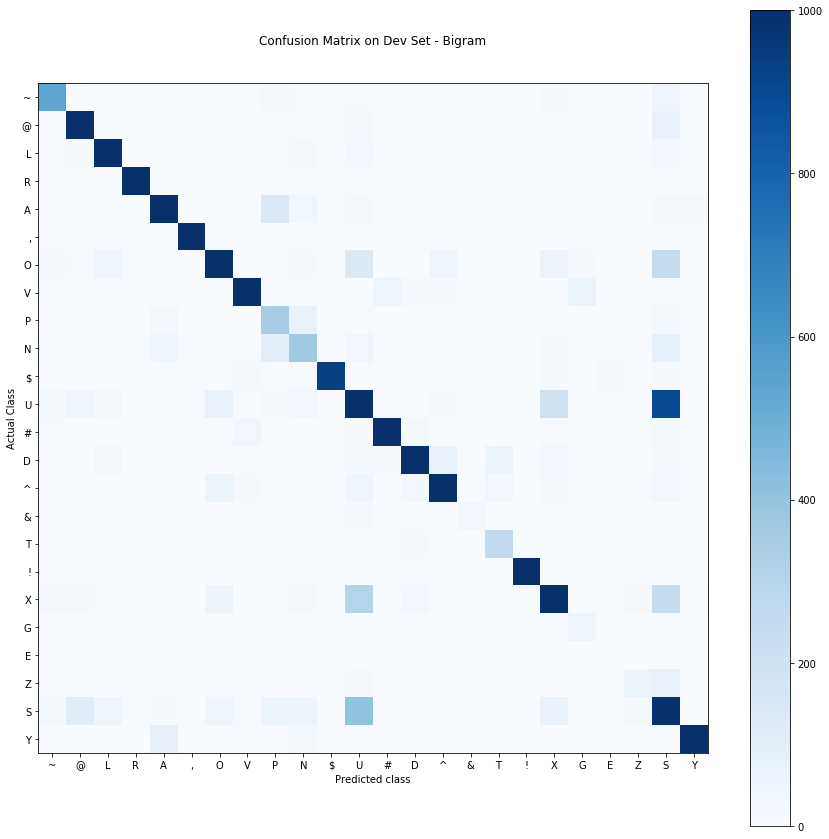

<Figure size 1080x1080 with 0 Axes>

In [226]:
plot_confusion_matrix(cnf_matrix_test, tags_overall, "Confusion Matrix on Dev Set - Bigram", "cnf_dev_bg")

Accuracy = 0.9249214531507147


/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


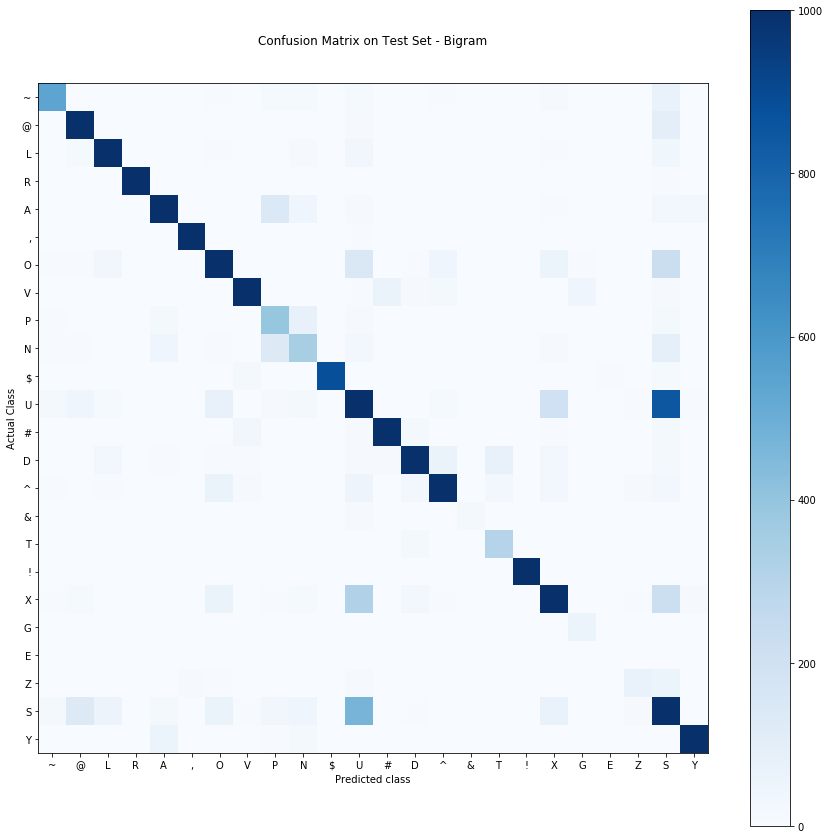

<Figure size 1080x1080 with 0 Axes>

In [227]:
test_emission_prob = emission_prob(test_tweets, train_tags_dict, new_pair_dict, train_vocab_dict_new)
acc, cnf_matrix = get_metrics_ea_cnf(2, tags_overall, bg_smoothed, test_emission_prob, test_tweets)
print ("Accuracy =", acc)
plot_confusion_matrix(cnf_matrix, tags_overall, "Confusion Matrix on Test Set - Bigram", "cnf_test_bg")

In [240]:
tg_smoothed = trigram_linear_interpolation(tags_overall, unigram_prob_dict, bigram_prob_dict, trigram_prob_dict, 0.8, 0.15,0.05)
accuracy, cnf_mat = get_metrics_ea_cnf(3, tags_overall, tg_smoothed, train_emission_prob, dev_tweets, ea=True)
print ("Accuracy =", accuracy)

(['OMFGGGGGGGGGG', '!'],) ['^']
(['Me', 'O'], ['hice', 'G'], ['re', 'G'], ['bosta', 'G'], ['mann', 'N']) ['O', 'Z', 'N', 'S', 'N']
(['RT', '~'], ['@IMxGxWxVI', '@'], [':', '~'], ['✳️ＯＮＬＹ', '^'], ['✳️ＩＦ', '^'], ['✳️ＹＯＵ', '^'], ['✳️ＦＯＬＬＯＷＢＡＣＫ', '^'], ['✳️', '^'], ['#MGWV', '^'], ['✳️', '^'], ['#RETWEET', '^'], ['✳️', '^'], ['#FOLLOWTRICK', '^'], ['✳️', '^'], ['#TEAMFOLLOWBACK', '^'], ['✳️', '^'], ['#ANOTHERFOLLOWTRAIN', '^'], ['✳️#ＦＯＬＬＯＷ', '^'], ['…', ',']) ['~', '@', '~', 'E', 'E', 'E', 'E', 'E', '#', 'E', '#', 'E', '#', 'E', '#', 'E', '#', 'E', 'E']
(['Colegiummmm', '!'],) ['^']
(['Rickey', '^'], ['👀🐇', '^'], ['https://t.co/sNXMTyCHPN', 'U']) ['S', 'G', 'U']
(['REQUEST', 'N'], ['FOR', 'P'], ['PROPOSALSREFUGEE', '^'], ['EMPLOYMENT', 'N'], [':', ','], ['REQUEST', 'N'], ['FOR', 'P'], ['PROPOSALS', 'N'], ['REFUGEE', 'N'], ['EMPLOYMENT', 'N'], ['AND', '&'], ['ACCULTURATION', 'N'], ['SERVICES', 'N'], ['T', 'G'], ['...', '~'], ['https://t.co/qUUNzTho4Z', 'U']) ['^', 'P', '^', '^', ',', '^', '

In [283]:
# tt = dev_tweets[1103]
# sent = []
# taggs = []
# for pair in tt:
#     sent.append(pair[0])
#     taggs.append(pair[1])
# predd = trigram_viterbi(tags_overall, tg_smoothed, train_emission_prob, sent)
# print (predd)

['^']


/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


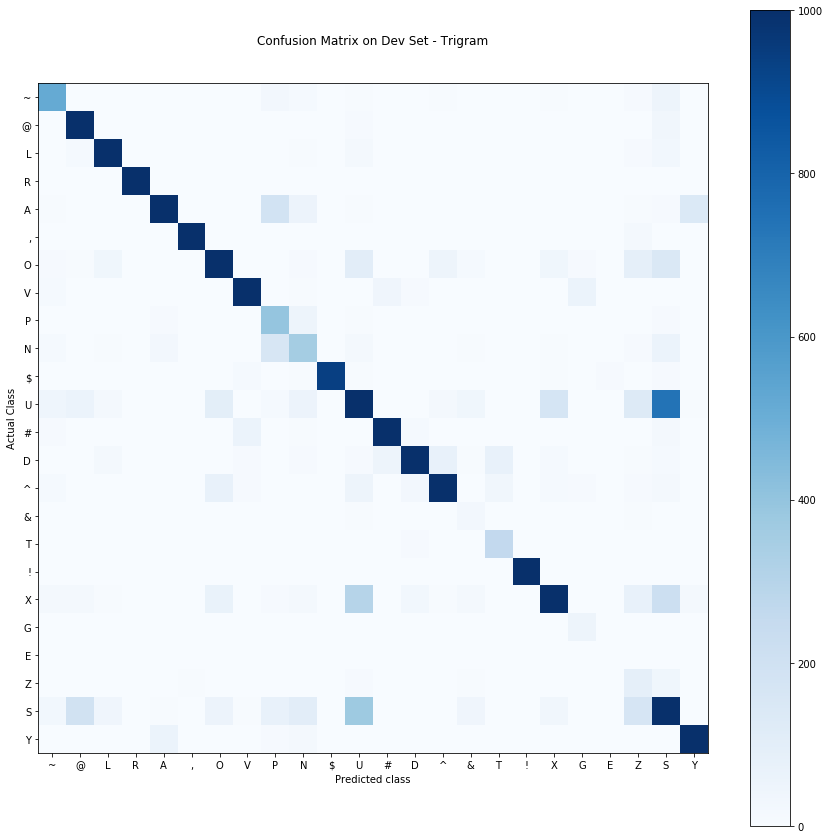

<Figure size 1080x1080 with 0 Axes>

In [224]:
plot_confusion_matrix(cnf_mat, tags_overall, "Confusion Matrix on Dev Set - Trigram", "cnf_dev_tg")

Accuracy = 0.9164207118860764


/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


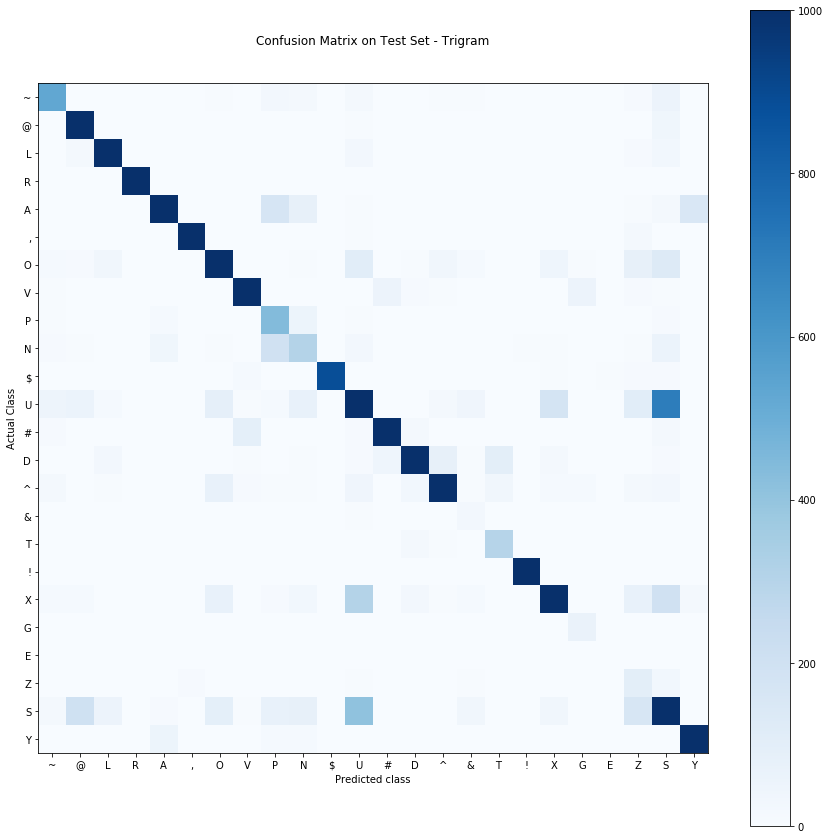

<Figure size 1080x1080 with 0 Axes>

In [228]:
accuracy, cnf_mat_test = get_metrics_ea_cnf(3, tags_overall, tg_smoothed, test_emission_prob, test_tweets, ea=False)
print ("Accuracy =", accuracy)
plot_confusion_matrix(cnf_mat_test, tags_overall, "Confusion Matrix on Test Set - Trigram", "cnf_test_tg")